In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np
from utils import *
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, Softmax, Reshape, Embedding
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import tensorflow as tf

In [3]:
# read embeddings
words_to_index, index_to_words, word_to_vec_map = load_glove_embeddings("glove.6B.50d.txt")

Reading embeddings file...


In [4]:
# ADD EOS token
np.random.seed(42)

orig_len = len(words_to_index)

words_to_index.update({"EOS": orig_len + 1})
index_to_words.update({orig_len + 1: "EOS"})
word_to_vec_map.update({"EOS": np.random.uniform(-0.1, 0.1, 50)})

# ADD unknown token
words_to_index.update({"UNK": orig_len + 2})
index_to_words.update({orig_len + 2: "UNK"})
word_to_vec_map.update({"UNK": np.random.uniform(-0.2, 0.2, 50)})

# ADD SOS token
words_to_index.update({"SOS": orig_len + 3})
index_to_words.update({orig_len + 3: "SOS"})
word_to_vec_map.update({"SOS": np.random.uniform(-0.3, 0.3, 50)})

len(words_to_index)
# print(index_to_words)

20003

In [11]:

print(y[0, :])

for index in y[0, :]:
    if index == 0:
        continue
    print(index_to_words[index], end=" ")



[20003.  8273. 14486.  6070.  7665. 20001.     0.]
SOS good quality dog food EOS 

In [12]:

data = pd.read_csv("Reviews.csv")
X = data["Text"].values[:100000]
y = data["Summary"].values[:100000]

In [13]:

# remove missing values
y_numeric = np.array([1 if isinstance(i, str) else np.nan for i in y])
X = X[~np.isnan(y_numeric)]
y = y[~np.isnan(y_numeric)]

In [14]:
# longest sequence of X: 2520 -> index 68700
# sequence will be 100 and could be hyper-tuned
Tx = 100

# longest sequence of Y: 31 -> index 539
# sequence will be 7
# made both decisions based on the histograms
Ty = 7

Most sentences in X are within 100 words
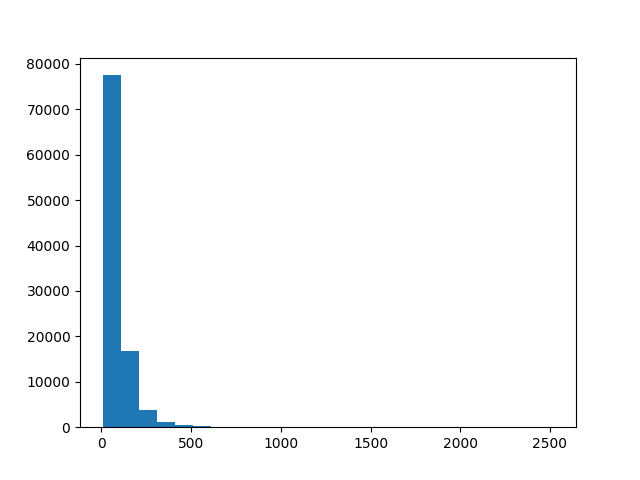

Most summaries are within 7 words

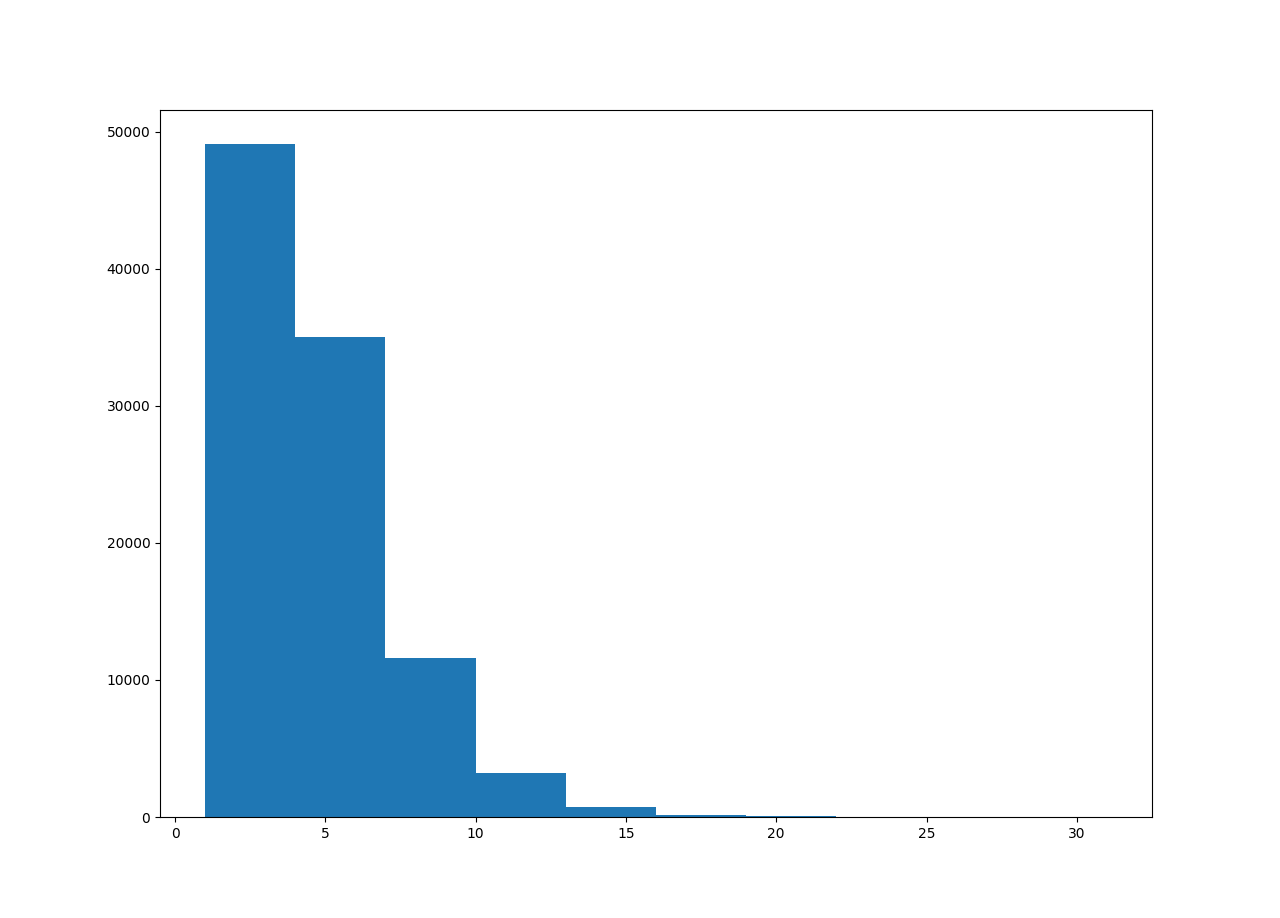

In [15]:
X = pre_process(X, Tx, words_to_index)
y = pre_process(y, Ty, words_to_index, add_eos=True)

In [16]:
print(X.shape)
print(y.shape)

(99998, 100)
(99998, 7)


In [17]:
print(np.sum(y == words_to_index["UNK"]) / (len(y) * Ty))
print(np.sum(X == words_to_index["UNK"]) / (len(X) * Tx))

0.05626255382250502
0.040207004140082804


In [18]:
for index in y[3, :]:
    if index == 0:
        continue
    print(index_to_words[index], end=" ")

SOS cough medicine EOS 

In [19]:
vocab_size = len(index_to_words) + 1

# fill embedding matrix with pretrained embeddings
embedding_matrix = np.zeros((vocab_size, 50))

for word, index in words_to_index.items():    
  embedding_matrix[index, :] = word_to_vec_map[word]

In [20]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_matrix, hidden_units, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_matrix = embedding_matrix
        self.hidden_units = hidden_units
        self.embedding = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False, mask_zero=True)
        
        self.bi_dir1 = Bidirectional(LSTM(units=hidden_units, return_sequences=True))
        self.bi_dir2 = Bidirectional(LSTM(units=hidden_units, return_sequences=True, return_state = True))
        
    def call(self, inputs):
        a, forward_s, forward_c, backward_s, backward_c = self.bi_dir2(self.bi_dir1(self.embedding(inputs)))
                
        s = tf.concat([forward_s, backward_s], -1)
        c = tf.concat([forward_c, backward_c], -1)
        
        return a, s, c        



In [21]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, enc_hid_dim  ,**kwargs):
        super().__init__(**kwargs)
        self.supports_masking=True
        self.densor1 = Dense(10, activation="tanh")
        self.dot = Dot(axes=1)
        self.densor2 = Dense(1, activation="relu")

    def call(self, inputs, mask=None):
        prev_hidden, encoder_outputs = inputs
        tx = encoder_outputs.shape[1]
        
        prev_hidden = tf.expand_dims(prev_hidden, 1)
        
        prev_hidden = tf.repeat(prev_hidden, repeats=tx, axis=1)
        
        concat = tf.concat([prev_hidden, encoder_outputs], -1)

        attention_scores = tf.nn.softmax(self.densor2(self.densor1(concat)), axis=1)

        context = self.dot([attention_scores, encoder_outputs])
        
        return context
        
    def compute_mask(self, inputs,  mask=None):
        # mask is a tuple of len 2 cuz inputs is a list of len 2
        # i am only checking for sec mask , cuz first to this layer is a hidden layer
        if mask[1] is not None:
            return tf.keras.ops.any(mask[1], axis=1, keepdims=True)
        else:
            return mask


In [22]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_matrix, enc_hid_dim, attentionLayer, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_matrix = embedding_matrix
        self.enc_hid_dim = enc_hid_dim
        self.attention = attentionLayer
        self.embedding = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False, mask_zero=True)
                
        self.lstm1 = LSTM(units=enc_hid_dim * 2,return_sequences=True)
        
        self.lstm3 = LSTM(units=enc_hid_dim * 2,return_state = True)
        
        self.lstm2 = LSTM(units=enc_hid_dim * 2, return_sequences=True)
        
        self.output_layer = Dense(vocab_size, activation='softmax', name="output_layer")
        
    def call(self, inputs, mask=None):
        # dec_inputs is one word only!!!
        dec_inputs, prev_hidden_s , prev_hidden_c, encoder_out = inputs

        embedded = tf.expand_dims(self.embedding(dec_inputs), 1)

        attention = self.attention([prev_hidden_s, encoder_out])

        rnn_input = tf.concat([embedded, attention], -1)

        output = self.lstm1(rnn_input, initial_state=[prev_hidden_s, prev_hidden_c])
        
        output2 = self.lstm2(output, initial_state=[prev_hidden_s, prev_hidden_c])
        
        _, hidden_s, hidden_c = self.lstm3( output2 ,initial_state= [prev_hidden_s, prev_hidden_c])
      
        pred = self.output_layer(hidden_s)

        return pred, hidden_s, hidden_c
    

In [95]:
enc_Hidden_dims = 256

encoder = Encoder(vocab_size, embedding_matrix, enc_Hidden_dims)
decoder = Decoder(vocab_size, embedding_matrix, enc_Hidden_dims , Attention(enc_Hidden_dims))


In [96]:
def get_model(Tx, Ty, teacher_forcing_ratio=0.5):
    X = Input(shape = (Tx, ))
    y = Input(shape = (Ty, ))
    
    outputs = []
    
    encoder_outputs, hidden_s, hidden_c = encoder(X)
    dec_input = y[:,  0]

    class argmax_onehot(tf.keras.Layer):
        def call(self, x):
            return tf.math.argmax(x, axis=-1)
            
    for t in range(1, Ty):
        output, hidden_s, hidden_c = decoder(
                [dec_input, hidden_s, hidden_c, encoder_outputs])

        teacher_force = random.random() < teacher_forcing_ratio        
        
        outputs.append(output)
        
        top1 = argmax_onehot()(output)
    
        dec_input = y[:, t] if teacher_force else top1
        
        
    model = Model(inputs=[X, y], outputs = outputs)        
    return model
    

In [97]:
model = get_model(Tx, Ty)

In [98]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, 7)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_16            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_44 (GetItem)     │ (None)                 │              0 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_4 (Encoder)       │ [(None, 100, 512),     │      3,203,848 │ input_layer_16[0][0]   │
│                           │ (None, 512), (None,    │                │                        │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_4 (Decoder)       │ [(None, 20004), (None, │     17,672,513 │ get_item_44[0][0],     │
│                           │ 512), (None, 512)]     │                │ encoder_4[0][1],       │
│                           │                        │                │ encoder_4[0][2],       │
│                           │                        │                │ encoder_4[0][0],       │
│                           │                        │                │ get_item_45[0][0],     │
│                           │                        │                │ decoder_4[0][1],       │
│                           │                        │                │ decoder_4[0][2],       │
│                           │                        │                │ encoder_4[0][0],       │
│                           │                        │                │ argmax_onehot_49[0][0… │
│                           │                        │                │ decoder_4[1][1],       │
│                           │                        │                │ decoder_4[1][2],       │
│                           │                        │                │ encoder_4[0][0],       │
│                           │                        │                │ argmax_onehot_50[0][0… │
│                           │                        │                │ decoder_4[2][1],       │
│                           │                        │                │ decoder_4[2][2],       │
│                           │                        │                │ encoder_4[0][0],       │
│                           │                        │                │ get_item_46[0][0],     │
│                           │                        │                │ decoder_4[3][1],       │
│                           │                        │                │ decoder_4[3][2],       │
│                           │                        │                │ encoder_4[0][0],       │
│                           │                        │                │ argmax_onehot_52[0][0… │
│                           │                        │                │ decoder_4[4][1],       │
│                           │                        │                │ decoder_4[4][2],       │
│                           │                        │                │ encoder_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_45 (GetItem)     │ (None)                 │              0 │ input_layer_17[0][0]   │
├──────────────────────

 Total params: 20,876,361 (79.64 MB)

 Trainable params: 18,875,961 (72.01 MB)

 Non-trainable params: 2,000,400 (7.63 MB)

In [109]:

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=8000,
    decay_rate=0.96,
    staircase=True
)

opt = Adam(lr_schedule)

model.compile(optimizer= opt, 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"] * (Ty - 1))


outputs = list(y.swapaxes(0, 1))

In [110]:
with tf.device('/GPU:0'):
    history = model.fit([X, y], outputs, epochs=20, verbose =1, batch_size = 64)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 188s 112ms/step - decoder_4_accuracy: 1.0000 - decoder_4_accuracy_1: 0.9816 - decoder_4_accuracy_2: 0.3137 - decoder_4_accuracy_3: 0.2999 - decoder_4_accuracy_4: 0.9832 - decoder_4_accuracy_5: 0.7053 - decoder_4_loss: 1.5636 - loss: 8.7548
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 176s 113ms/step - decoder_4_accuracy: 1.0000 - decoder_4_accuracy_1: 0.9926 - decoder_4_accuracy_2: 0.3278 - decoder_4_accuracy_3: 0.3108 - decoder_4_accuracy_4: 0.9941 - decoder_4_accuracy_5: 0.7128 - decoder_4_loss: 1.4602 - loss: 8.2073
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 176s 113ms/step - decoder_4_accuracy: 1.0000 - decoder_4_accuracy_1: 0.9956 - decoder_4_accuracy_2: 0.3429 - decoder_4_accuracy_3: 0.3206 - decoder_4_accuracy_4: 0.9969 - decoder_4_accuracy_5: 0.7191 - decoder_4_loss: 1.3821 - loss: 7.7947
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 176s 113ms/step - decoder_4_accuracy: 1.0000 - decoder_4_accuracy_1: 0.9975 - decoder_4_accuracy_2: 0.3602 - dec

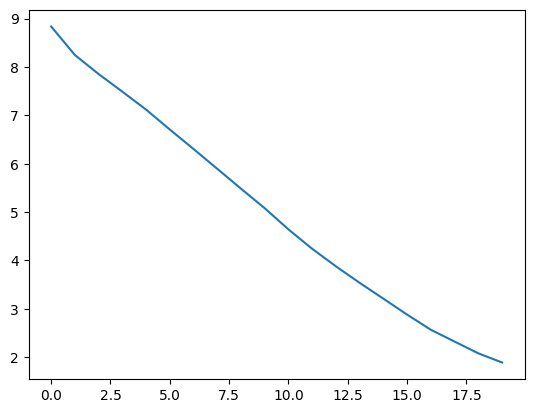

In [111]:
plt.plot(history.history["loss"])